In [ ]:
import tensorflow as tf

import os
import tensorflow_datasets as tfds

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
from google.colab  import drive
drive.mount("/gdrive")
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
directory_path='/gdrive/My Drive/Yedek/Video_Dataset_hsv'

In [ ]:
subset_paths={'train':directory_path+'/train','test':directory_path+'/test'}

In [ ]:
!pip install hickle
import hickle as hkl
import random
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
from random import randint
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def frames_from_video_file(video_path):
  result = []
  src = cv2.VideoCapture(str(video_path))

  for _ in range(0,20,2):
    ret, frame = src.read()
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    tf.image.resize(frame, [456,456])
    result.append(frame)
  src.release()
  result = np.array(result)[..., [2, 1, 0]]
  return result

In [ ]:
class FrameGenerator:
  def __init__(self, path, training = False):

    self.path = path
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
train_path = Path(subset_paths['train'])
test_path = Path(subset_paths['test'])

In [ ]:
fg = FrameGenerator(train_path, training=True)
print(fg.class_ids_for_name)

{'healthy': 0, 'sick': 1}


In [ ]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.float32))

In [ ]:
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_path, training=True),
                                          output_signature = output_signature)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_path, training=False),
                                          output_signature = output_signature)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [ ]:
train_ds = train_ds.batch(16)
test_ds = test_ds.batch(16)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Shape of training set of frames: (16, 10, 480, 640, 3)
Shape of training labels: (16,)
Shape of validation set of frames: (16, 10, 480, 640, 3)
Shape of validation labels: (16,)


In [ ]:
def build_efficient():
    inputs = tf.keras.layers.Input(shape=(456, 456, 3))
    model = tf.keras.applications.EfficientNetB5(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    model = tf.keras.Sequential([model,tf.keras.layers.GlobalAveragePooling2D(),tf.keras.layers.BatchNormalization()])

    return model

In [ ]:
with strategy.scope():
  net=build_efficient()

  model = tf.keras.Sequential([
      tf.keras.layers.Rescaling(scale=255),
      tf.keras.layers.TimeDistributed(net),
      tf.keras.layers.LSTM(24),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(8),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(4),
      tf.keras.layers.Dense(1,'sigmoid')
  ])

  model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3,  use_ema=True, ema_momentum = 0.8, weight_decay=0.1),
                loss='mse', metrics=tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5))

In [ ]:
epochs=20

In [ ]:
model.fit(train_ds, epochs = epochs)

Epoch 1/20
11/11 [==============================] - 80s 856ms/step - loss: 0.2475 - binary_accuracy: 0.6136
Epoch 2/20
11/11 [==============================] - 10s 846ms/step - loss: 0.1619 - binary_accuracy: 0.7955
Epoch 3/20
11/11 [==============================] - 9s 838ms/step - loss: 0.1701 - binary_accuracy: 0.7557
Epoch 4/20
11/11 [==============================] - 10s 851ms/step - loss: 0.1541 - binary_accuracy: 0.7784
Epoch 5/20
11/11 [==============================] - 9s 830ms/step - loss: 0.1573 - binary_accuracy: 0.7784
Epoch 6/20
11/11 [==============================] - 9s 826ms/step - loss: 0.1712 - binary_accuracy: 0.7557
Epoch 7/20
11/11 [==============================] - 9s 821ms/step - loss: 0.1249 - binary_accuracy: 0.8295
Epoch 8/20
11/11 [==============================] - 9s 833ms/step - loss: 0.1171 - binary_accuracy: 0.8068
Epoch 9/20
11/11 [==============================] - 9s 831ms/step - loss: 0.1243 - binary_accuracy: 0.8125
Epoch 10/20
11/11 [===============

In [ ]:
def get_actual_labels(dataset):
  actual = [labels for _, labels in dataset.unbatch()]
  actual = tf.stack(actual, axis=0)
  return actual

In [ ]:
model.evaluate(test_ds ,return_dict=True)

5/5 [==============================] - 36s 736ms/step - loss: 0.0938 - binary_accuracy: 0.9079


{'loss': 0.09380945563316345, 'binary_accuracy': 0.9078947305679321}

In [ ]:
import seaborn as sns

In [ ]:
actual = get_actual_labels(test_ds)

In [ ]:
y_pred=model.predict(test_ds)
y_pred=np.where(y_pred > 0.5, 1,0)

5/5 [==============================] - 36s 759ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

cm=confusion_matrix(actual, y_pred)
print(cm)
print(classification_report(actual, y_pred))

[[45  3]
 [ 4 24]]
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93        48
         1.0       0.89      0.86      0.87        28

    accuracy                           0.91        76
   macro avg       0.90      0.90      0.90        76
weighted avg       0.91      0.91      0.91        76



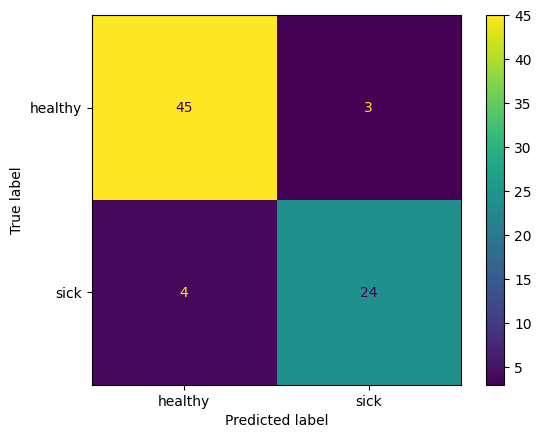

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['healthy','sick'])
sns.reset_orig()
disp.plot()